# Welcome to this lovely notebook. This is the extention of the notebook EDA with data preprocessing and modeling parts (CatBoost)

## In this notebook we are going to implement the following:

1. Runnig the base version of CatBoost
2. After running the base version of the model, we'll find the best downsampled version of data and best hyper parameters for highest recall and precision

## Importing all required libraries

In [1]:
#importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import shap
from datetime import datetime

# Set the option to display all columns
pd.set_option('display.max_columns', None)

# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,\
classification_report, precision_recall_curve, auc, make_scorer, fbeta_score

# Encoding
from sklearn.preprocessing import OneHotEncoder

# Machine Learning - Preparation
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, SelectKBest

# Machine Learning - Algorithm
from catboost import CatBoostClassifier

C:\Users\atans\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 Let's get the data

In [2]:
train = pd.read_csv('fraudTrain.csv', index_col=0)
test = pd.read_csv('fraudTest.csv', index_col=0)

## 2 Let's split the data

In [3]:
X_train = train.drop(columns=['is_fraud'])
y_train = train['is_fraud']

X_test = test.drop(columns=['is_fraud'])
y_test = test['is_fraud']

## 3 Creating additional columns which will be used

The columns that have to be added:
1. Day of week
2. Month
3. Hour
4. Age of user

In [5]:
current_date = datetime.now()

for dataset in [X_train, X_test]:
    dataset['trans_date_trans_time'] = pd.to_datetime(dataset['trans_date_trans_time'])
    dataset['dob'] = pd.to_datetime(dataset['dob'])
    dataset['day_of_week'] = dataset['trans_date_trans_time'].dt.day_name()
    dataset['month'] = dataset['trans_date_trans_time'].dt.month
    dataset['hour'] = dataset['trans_date_trans_time'].dt.hour
    dataset['age'] =dataset['dob'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

## 4 Dropping the columns we are not going to use

In [6]:
X_train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'day_of_week', 'month', 'hour', 'age'],
      dtype='object')

In [7]:
for dataset in [X_train, X_test]:
    dataset.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',\
                            'zip', 'dob', 'trans_num', 'unix_time', 'lat', 'long', 'merch_lat', 'merch_long'], axis=1, inplace=True)

## 4.1 Encoding categorical features and running 'trial' models

In [8]:
X_train.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'city_pop',
       'job', 'day_of_week', 'month', 'hour', 'age'],
      dtype='object')

In [9]:
%%time
# Step 1: Separate categorical and numerical columns
categorical_columns = ['merchant', 'category', 'gender', 'city', 'state', 'job', 'day_of_week']
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # drop='first' to avoid multicollinearity

# Step 3: Apply OneHotEncoder to the categorical columns in X_train (fit the encoder)
encoded_categorical_train = encoder.fit_transform(X_train[categorical_columns])

# Step 4: Convert the encoded categorical data back to a DataFrame for X_train
encoded_df_train = pd.DataFrame(encoded_categorical_train, columns=encoder.get_feature_names_out(categorical_columns))

# Step 5: Concatenate the numerical columns with the encoded categorical columns for X_train
X_train_encoded = pd.concat([X_train[numerical_columns].reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)

# Now apply the same transformation to the test data (use transform instead of fit_transform)
encoded_categorical_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded categorical data back to a DataFrame for X_test
encoded_df_test = pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the numerical columns with the encoded categorical columns for X_test
X_test_encoded = pd.concat([X_test[numerical_columns].reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: total: 59 s
Wall time: 2min 25s


#### Removing some special symbols from the names of the features

In [13]:
X_train_encoded.columns = X_train_encoded.columns.str.replace(r'[^\w]', '_', regex=True)
X_test_encoded.columns = X_test_encoded.columns.str.replace(r'[^\w]', '_', regex=True)

#### Saving encoded train adn test data

In [14]:
X_train_encoded.to_parquet('X_train_encoded.csv', index=False)
X_test_encoded.to_parquet('X_test_encoded.csv', index=False)

#### Opening encoded train adn test data

In [4]:
X_train_encoded = pd.read_parquet('X_train_encoded.csv')
X_test_encoded = pd.read_parquet('X_test_encoded.csv')

### 5.1 Testing LightGBM with binary_logloss metric

In [15]:
%%time
# Step 1: Initialize the XGBoost Classifier
model_5 = CatBoostClassifier(loss_function='Logloss', eval_metric='Logloss', verbose=0)

# Step 2: Train the model on the training data
model_5.fit(X_train_encoded, y_train)

# Step 3: Predict on the training data
y_train_pred = model_5.predict(X_train_encoded)

# Step 4: Predict on the test data
y_test_pred = model_5.predict(X_test_encoded)

# Step 5: Generate the classification report for training data
print("Classification Report for Training Data:")
print(classification_report(y_train, y_train_pred))

# Step 6: Generate the classification report for test data
print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_test_pred))

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.93      0.73      0.82      7506

    accuracy                           1.00   1296675
   macro avg       0.96      0.87      0.91   1296675
weighted avg       1.00      1.00      1.00   1296675


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.73      0.46      0.56      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.73      0.78    555719
weighted avg       1.00      1.00      1.00    555719

CPU times: total: 2min 4s
Wall time: 1min 7s


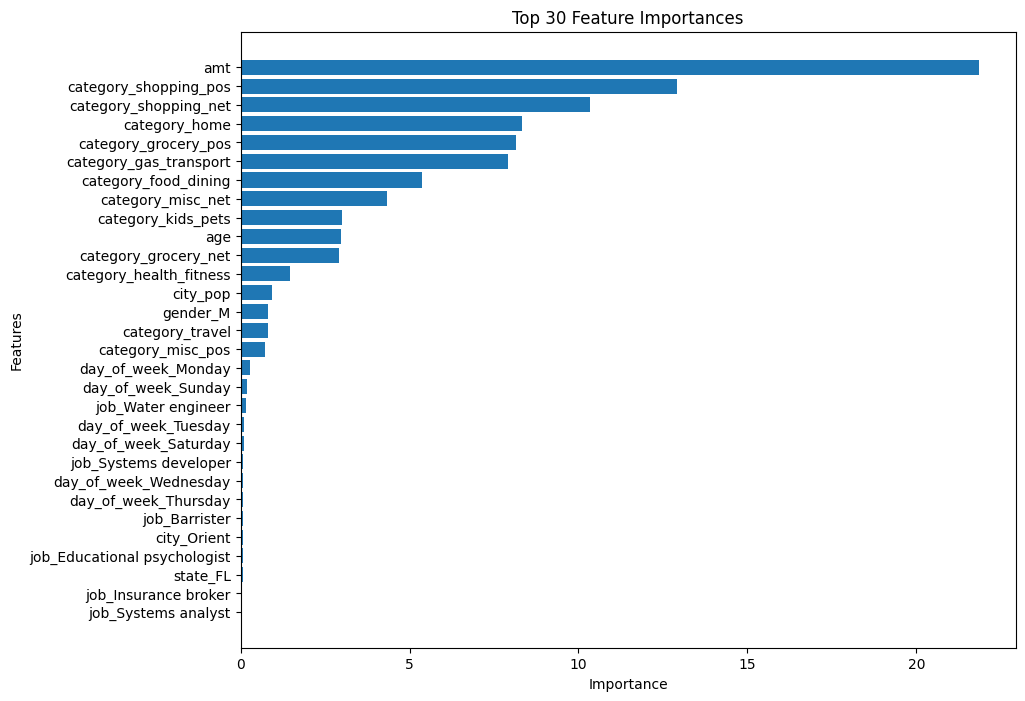

In [12]:
# Get the feature importances
feature_importances = model_5.get_feature_importance(type='PredictionValuesChange')

# Get the feature names
feature_names = model_5.feature_names_

# Combine feature names and their importances into a list of tuples
feature_importance_list = list(zip(feature_names, feature_importances))

# Sort the features by importance in descending order and select the top 30
top_30_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)[:30]

# Separate the top 30 features into names and importance values
top_30_names, top_30_importances = zip(*top_30_features)

# Plot the top 30 features
plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(top_30_importances)), top_30_importances, align='center')
plt.yticks(np.arange(len(top_30_importances)), top_30_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [14]:
#Looks relatively ok
#Interestingly enough the features the model used look different from the features
#which were used by XGBoost and LightGBM

In [11]:
# Now we can try a few more things like:
# 1. We can try to downsample the train data and see if it improves the results
# 2. We can try to play with hyper parameters

### 5.2 Trying downsampling of not fraudulent rows of train data all the possible features, apart from long and lat and testing LightGBM with binary_logloss metric

### Running a loop with various downsample options

In [4]:
%%time

X_train_encoded_5_2 = pd.read_parquet('X_train_encoded.csv')
X_test_encoded_5_2 = pd.read_parquet('X_test_encoded.csv')

# Reset the indices to align them
X_train_encoded_5_2 = X_train_encoded_5_2.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Separate majority class (0s) and minority class (1s)
X_train_encoded_0 = X_train_encoded_5_2[y_train == 0]
X_train_encoded_1 = X_train_encoded_5_2[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]


for frac in [1.0, 0.8, 0.5, 0.25, 0.1, 0.05]:

    # Step 2: Downsample the majority class (0s) by frac
    # Downsample X_train_encoded_0 and use its indices to select the corresponding rows from y_train_0
    X_train_0_downsampled = X_train_encoded_0.sample(frac=frac, random_state=42)
    y_train_0_downsampled = y_train_0.loc[X_train_0_downsampled.index]  # Use the same indices for y_train

    # Step 3: Concatenate the downsampled majority class with the minority class
    X_train_downsampled = pd.concat([X_train_0_downsampled, X_train_encoded_1])
    y_train_downsampled = pd.concat([y_train_0_downsampled, y_train_1])

    # Step 4: Shuffle the dataset to mix the downsampled rows
    X_train_downsampled_5_2 = X_train_downsampled.sample(frac=1, random_state=42)
    y_train_downsampled_5_2 = y_train_downsampled.loc[X_train_downsampled_5_2.index]  # Align y_train after shuffling

    # Step 5: Initialize the XGBoost Classifier
    model_5_2 = CatBoostClassifier(loss_function='Logloss', eval_metric='Logloss', verbose=0)
    
    # Step 6: Train the model on the training data
    model_5_2.fit(X_train_downsampled_5_2, y_train_downsampled_5_2)

    # Step 7: Predict on the training data
    y_train_pred = model_5_2.predict(X_train_downsampled_5_2)

    # Step 8: Predict on the test data
    y_test_pred = model_5_2.predict(X_test_encoded_5_2)

    print('\n')
    print(f'This is a set of results for frac: {frac*100} %')
    print('\n')

    # Step 9: Generate the classification report for training data
    print("Classification Report for Training Data:")
    print(classification_report(y_train_downsampled_5_2, y_train_pred))

    # Step 10: Generate the classification report for test data
    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))



This is a set of results for frac: 100.0 %


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.92      0.72      0.81      7506

    accuracy                           1.00   1296675
   macro avg       0.96      0.86      0.90   1296675
weighted avg       1.00      1.00      1.00   1296675


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.73      0.47      0.57      2145

    accuracy                           1.00    555719
   macro avg       0.87      0.73      0.78    555719
weighted avg       1.00      1.00      1.00    555719



This is a set of results for frac: 80.0 %


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1031335
           1       0.90 

## So we see the following:
1. In terms of imbalanced data, training Catboost on 50% of train data + all fraud gives pretty balanced results
2. Almost all features are used
3. The current run took 13 mins

### 5.3 Trying to run some hyper parameter tuning on 50% downsampling

In [4]:
%%time

X_train_encoded_5_3 = pd.read_parquet('X_train_encoded.csv')
X_test_encoded_5_3 = pd.read_parquet('X_test_encoded.csv')

# Reset the indices to align them
X_train_encoded_5_3 = X_train_encoded_5_3.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Separate majority class (0s) and minority class (1s)
X_train_encoded_0 = X_train_encoded_5_3[y_train == 0]
X_train_encoded_1 = X_train_encoded_5_3[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

# Step 2: Downsample the majority class (0s) by frac
# Downsample X_train_encoded_0 and use its indices to select the corresponding rows from y_train_0
X_train_0_downsampled = X_train_encoded_0.sample(frac=0.5, random_state=42)
y_train_0_downsampled = y_train_0.loc[X_train_0_downsampled.index]  # Use the same indices for y_train

# Step 3: Concatenate the downsampled majority class with the minority class
X_train_downsampled = pd.concat([X_train_0_downsampled, X_train_encoded_1])
y_train_downsampled = pd.concat([y_train_0_downsampled, y_train_1])

# Step 4: Shuffle the dataset to mix the downsampled rows
X_train_downsampled_5_3 = X_train_downsampled.sample(frac=1, random_state=42)
y_train_downsampled_5_3 = y_train_downsampled.loc[X_train_downsampled_5_3.index]  # Align y_train after shuffling

for max_depth in [3, 5, 7]:
    for learning_rate in [0.05, 0.1, 0.2]:
        for n_estimators in [100, 200]:
            for scale_pos_weight in [0.6, 0.8, 1]:
                # Step 5: Initialize the Light GBM
                model_5_3 = CatBoostClassifier(
                                                    loss_function='Logloss',
                                                    depth=max_depth,
                                                    iterations=n_estimators,
                                                    learning_rate=learning_rate,
                                                    scale_pos_weight=scale_pos_weight,
                                                    verbose=0
                                                ) 

                # Step 6: Train the model on the training data
                model_5_3.fit(X_train_downsampled_5_3, y_train_downsampled_5_3)

                # Step 7: Predict on the training data
                y_train_pred = model_5_3.predict(X_train_downsampled_5_3)

                # Step 8: Predict on the test data
                y_test_pred = model_5_3.predict(X_test_encoded_5_3)

                print('\n')
                print(f'This is a set of results for 50% downsampling, depth={max_depth}, learning_rate={learning_rate}, n_estimators={n_estimators}, scale_pos_weight={scale_pos_weight}')
                print('\n')
                #print how many features were used:

                # Step 9: Generate the classification report for training data
                print("Classification Report for Training Data:")
                print(classification_report(y_train_downsampled_5_3, y_train_pred))

                # Step 10: Generate the classification report for test data
                print("\nClassification Report for Test Data:")
                print(classification_report(y_test, y_test_pred))



This is a set of results for 50% downsampling, depth=3, learning_rate=0.05, n_estimators=100, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    644584
           1       0.87      0.51      0.64      7506

    accuracy                           0.99    652090
   macro avg       0.93      0.75      0.82    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.69      0.51      0.58      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.75      0.79    555719
weighted avg       1.00      1.00      1.00    555719



This is a set of results for 50% downsampling, depth=3, learning_rate=0.05, n_estimators=100, scale_pos_weight=0.8


Classification Report for Tra



This is a set of results for 50% downsampling, depth=3, learning_rate=0.1, n_estimators=200, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.85      0.65      0.74      7506

    accuracy                           0.99    652090
   macro avg       0.92      0.83      0.87    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.65      0.64      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.82      0.82    555719
weighted avg       1.00      1.00      1.00    555719



This is a set of results for 50% downsampling, depth=3, learning_rate=0.1, n_estimators=200, scale_pos_weight=1


Classification Report for Trainin



This is a set of results for 50% downsampling, depth=5, learning_rate=0.05, n_estimators=100, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.66      0.74      7506

    accuracy                           0.99    652090
   macro avg       0.92      0.83      0.87    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.64      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.82      0.82    555719
weighted avg       1.00      1.00      1.00    555719



This is a set of results for 50% downsampling, depth=5, learning_rate=0.05, n_estimators=200, scale_pos_weight=0.6


Classification Report for Train



This is a set of results for 50% downsampling, depth=5, learning_rate=0.2, n_estimators=100, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.90      0.64      0.75      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.82      0.87    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.75      0.60      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.87      0.80      0.83    555719
weighted avg       1.00      1.00      1.00    555719



This is a set of results for 50% downsampling, depth=5, learning_rate=0.2, n_estimators=100, scale_pos_weight=0.8


Classification Report for Train



This is a set of results for 50% downsampling, depth=7, learning_rate=0.05, n_estimators=200, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.88      0.68      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.84      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.70      0.65      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.83      0.84    555719
weighted avg       1.00      1.00      1.00    555719



This is a set of results for 50% downsampling, depth=7, learning_rate=0.05, n_estimators=200, scale_pos_weight=1


Classification Report for Train



This is a set of results for 50% downsampling, depth=7, learning_rate=0.2, n_estimators=100, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.73      0.79      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.87      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.67      0.69      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.84      0.84    555719
weighted avg       1.00      1.00      1.00    555719



This is a set of results for 50% downsampling, depth=7, learning_rate=0.2, n_estimators=200, scale_pos_weight=0.6


Classification Report for Trainin

#### Best hyper parameters and results

In [12]:
print("""
This is a set of results for 50% downsampling, depth=7, learning_rate=0.2, n_estimators=100, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.91      0.65      0.76      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.83      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.76      0.61      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.81      0.84    555719
weighted avg       1.00      1.00      1.00    555719
""")


This is a set of results for 50% downsampling, depth=7, learning_rate=0.2, n_estimators=100, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.91      0.65      0.76      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.83      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.76      0.61      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.81      0.84    555719
weighted avg       1.00      1.00      1.00    555719



### Conclusion
1. Best training sample was 50% downsampled
2. Best results in this case are : 76% recall and 61% precision
3. Best set of params found: max_depth=7, learning_rate=0.2, n_estimators=100, scale_pos_weight=0.6

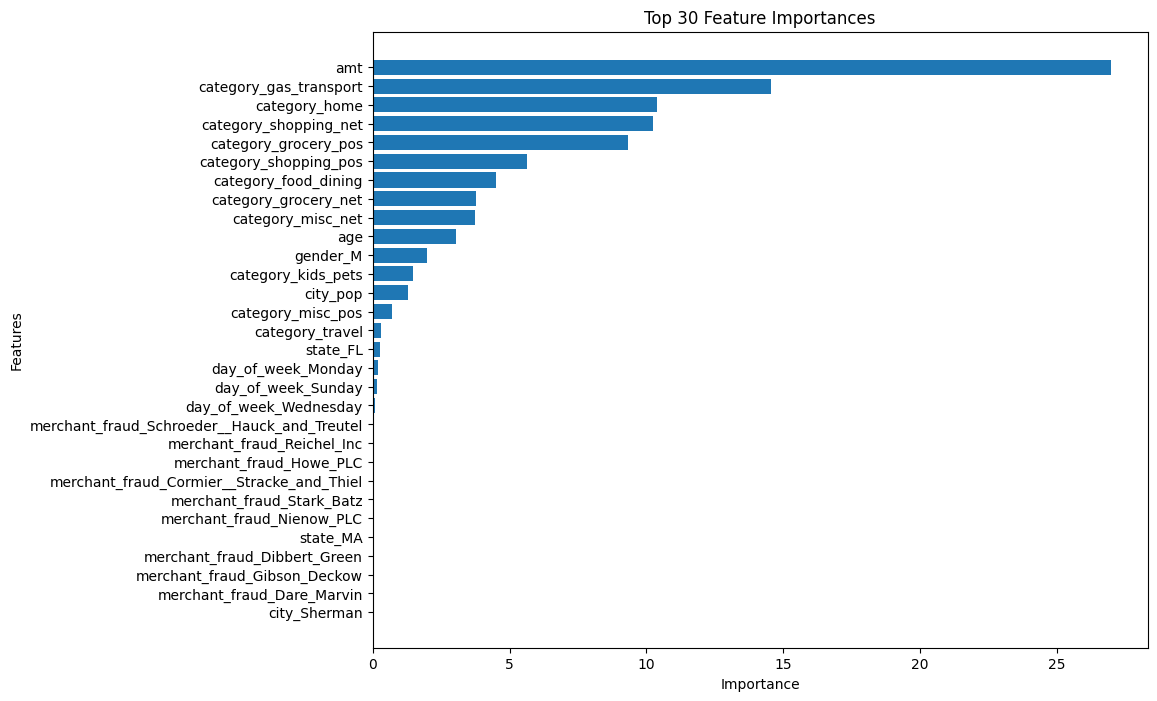

In [11]:
# Get the feature importances of the best model
feature_importances = model_6.get_feature_importance(type='PredictionValuesChange')

# Get the feature names
feature_names = model_6.feature_names_

# Combine feature names and their importances into a list of tuples
feature_importance_list = list(zip(feature_names, feature_importances))

# Sort the features by importance in descending order and select the top 30
top_30_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)[:30]

# Separate the top 30 features into names and importance values
top_30_names, top_30_importances = zip(*top_30_features)

# Plot the top 30 features
plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(top_30_importances)), top_30_importances, align='center')
plt.yticks(np.arange(len(top_30_importances)), top_30_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

## 6 Summary plot with shap

#### Prepare the data

In [4]:
%%time

X_train_encoded_6 = pd.read_parquet('X_train_encoded.csv')
X_test_encoded_6 = pd.read_parquet('X_test_encoded.csv')

# Reset the indices to align them
X_train_encoded_6 = X_train_encoded_6.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Separate majority class (0s) and minority class (1s)
X_train_encoded_0 = X_train_encoded_6[y_train == 0]
X_train_encoded_1 = X_train_encoded_6[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

# Step 2: Downsample the majority class (0s) by frac
# Downsample X_train_encoded_0 and use its indices to select the corresponding rows from y_train_0
X_train_0_downsampled = X_train_encoded_0.sample(frac=0.5, random_state=42)
y_train_0_downsampled = y_train_0.loc[X_train_0_downsampled.index]  # Use the same indices for y_train

# Step 3: Concatenate the downsampled majority class with the minority class
X_train_downsampled = pd.concat([X_train_0_downsampled, X_train_encoded_1])
y_train_downsampled = pd.concat([y_train_0_downsampled, y_train_1])

# Step 4: Shuffle the dataset to mix the downsampled rows
X_train_downsampled_6 = X_train_downsampled.sample(frac=1, random_state=42)
y_train_downsampled_6 = y_train_downsampled.loc[X_train_downsampled_6.index]

CPU times: total: 4min 50s
Wall time: 2min 24s


In [5]:
# Get all opened DataFrames in the current environment
dfs = [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]

print("List of DataFrames currently in memory:")
print(dfs)

List of DataFrames currently in memory:
['train', 'test', 'X_train', 'X_test', 'X_train_encoded_6', 'X_test_encoded_6', 'X_train_encoded_0', 'X_train_encoded_1', 'X_train_0_downsampled', 'X_train_downsampled', 'X_train_downsampled_6']


In [6]:
del train, test, X_train, X_test, X_train_encoded_6, X_train_encoded_0, X_train_encoded_1, X_train_0_downsampled, X_train_downsampled

In [7]:
model_6 = CatBoostClassifier(
                                                    loss_function='Logloss',
                                                    depth=7,
                                                    iterations=100,
                                                    learning_rate=0.2,
                                                    scale_pos_weight=0.6,
                                                    verbose=0
                                                )   

# Step 1: Train the model on the training data
model_6.fit(X_train_downsampled_6, y_train_downsampled_6)

# Step 2: Predict on the training data
y_train_pred = model_6.predict(X_train_downsampled_6)

# Step 3: Predict on the test data
y_test_pred = model_6.predict(X_test_encoded_6)

# Step 4: Generate the classification report for training data
print("Classification Report for Training Data:")
print(classification_report(y_train_downsampled_6, y_train_pred))

# Step 5: Generate the classification report for test data
print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_test_pred))

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.91      0.65      0.76      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.83      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.76      0.61      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.81      0.84    555719
weighted avg       1.00      1.00      1.00    555719



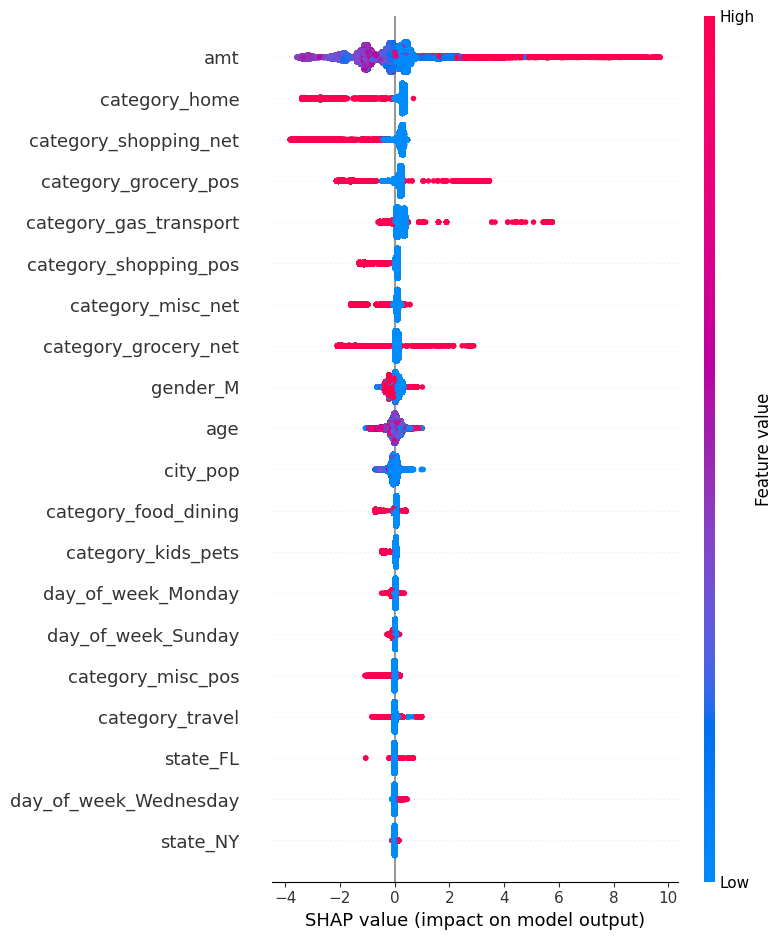

In [10]:
#Use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(model_6)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test_encoded_6)

# Plot summary plot (feature importance plot) for top 20 features
shap.summary_plot(shap_values, X_test_encoded_6, max_display=20)